# ТМ для новостей

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
df = pd.read_csv('../data/news.csv')
df.sort_values(by = ['event'], inplace = True)
df.head()

,Unnamed: 0,event,text
297,297,CNN показала фильм «Владимир Путин — самый вли...,CNN: ВЛАДИМИР ПУТИН - САМЫЙ МОГУЩЕСТВЕННЫЙ ЧЕ...
298,298,CNN показала фильм «Владимир Путин — самый вли...,"РБК (rbc.ru), Москва, 14 марта 2017 КРЕМЛЬ ПР..."
678,678,SpaceX впервые в истории запустила и посадила ...,"Newstes.ru, Москва, 31 марта 2017 ПОЛЕТ НОРМА..."
679,679,SpaceX впервые в истории запустила и посадила ...,"Vistanews.ru, Москва, 31 марта 2017 SPACE X В..."
680,680,SpaceX впервые в истории запустила и посадила ...,"Russia Today (russian.rt.com), Москва, 31 мар..."


In [3]:
df.event.value_counts()

Чемпионат мира по хоккею                                                                                    102
Кубок конфедерации FiFA                                                                                     100
Правительство внесло в Госдуму законопроект о курортных сборах                                              100
Митинг в москве против коррупции                                                                            100
Теракт в Барселоне                                                                                          100
Власти Петербурга согласились передать РПЦ Исаакиевский собор.                                              100
Акции протеста 12 июня                                                                                      100
Саммит G20                                                                                                  100
Ураган в Москве                                                                                         

### Препроцессинг

In [4]:
import re
from nltk.corpus import stopwords

In [5]:
from pymystem3 import Mystem
m = Mystem()

In [6]:
mystopwords = stopwords.words('russian') + [
    'это', 'наш' , 'тыс', 'млн', 'млрд', 'также',  'т', 'д',
    'который','прошлый','сей', 'свой', 'наш', 'мочь', 'такой'
]
ru_words = re.compile("[А-Яа-я]+")


def words_only(text):
    return " ".join(ru_words.findall(text))


def lemmatize(text, mystem=m):
    try:
        return "".join(m.lemmatize(text)).strip()  
    except:
        return " "


def remove_stopwords(text, mystopwords = mystopwords):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return ""

    
def preprocess(text):
    return remove_stopwords(lemmatize(words_only(text.lower())))

In [7]:
%%time
df.text = df.text.apply(preprocess)

CPU times: user 8.14 s, sys: 296 ms, total: 8.44 s
Wall time: 58.3 s


## Генсим

### TfidfModel

In [15]:
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim import similarities

In [16]:
texts = [text.split() for text in df.text]
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [18]:
# dictionary.token2id

In [ ]:
# поизучаем, что здесь происходит


Косинусная близость:


$$similarity=\cos(\theta )={\mathbf {A} \cdot \mathbf {B}  \over \|\mathbf {A} \|\|\mathbf {B} \|}={\frac {\sum \limits _{i=1}^{n}{A_{i}B_{i}}}{{\sqrt {\sum \limits _{i=1}^{n}{A_{i}^{2}}}}{\sqrt {\sum \limits _{i=1}^{n}{B_{i}^{2}}}}}}$$

Вычисление сходства по косинусной мере на векторах $tf-idf$:

In [17]:
tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [18]:
%%time
index = similarities.MatrixSimilarity(corpus_tfidf)
sims = index[corpus_tfidf]

CPU times: user 14.7 s, sys: 1.25 s, total: 16 s
Wall time: 10.3 s


In [19]:
sims[0]

array([0.99999994, 0.39502093, 0.01790708, ..., 0.04971402, 0.0161962 ,
       0.00552976], dtype=float32)

In [20]:
import seaborn as sns

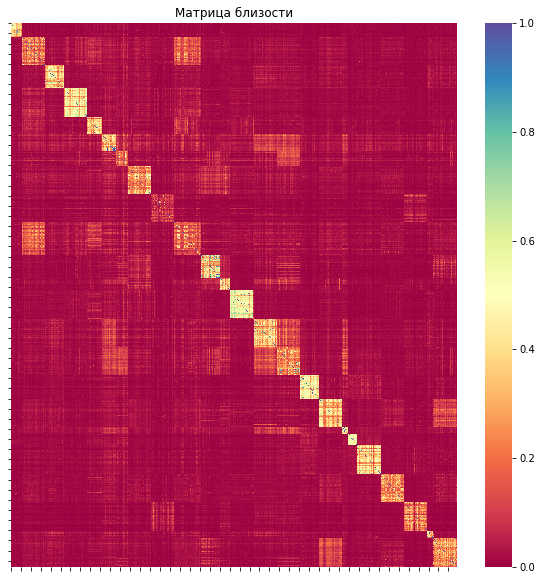

In [21]:
plt.figure(figsize = (10,10))
sns.heatmap(data=sims, cmap = 'Spectral').set(xticklabels=[],yticklabels=[])
plt.title("Матрица близости")
plt.show()

### Латентно-семантический анализ (LSA, LSI)


Сингулярное разложение: $M'_k = U \Sigma_k V^t_k$

* $M$ – матрица слово-документ
* $U$ – матрица слово-тема
* $k$ – число тем
* $V$ - матрица документ-тема

In [22]:
from gensim.models import lsimodel

In [23]:
%%time
lsi = lsimodel.LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=30)

CPU times: user 7.96 s, sys: 1.79 s, total: 9.75 s
Wall time: 4.73 s


In [24]:
lsi.show_topics(5)

[(0,
  '0.224*"путин" + 0.166*"трамп" + 0.148*"меркель" + 0.133*"президент" + 0.127*"выборы" + 0.117*"курортный" + 0.113*"навальный" + 0.113*"акция" + 0.110*"теракт" + 0.103*"сбор"'),
 (1,
  '-0.551*"курортный" + -0.466*"сбор" + -0.234*"законопроект" + -0.212*"эксперимент" + -0.158*"инфраструктура" + -0.148*"введение" + -0.129*"вносить" + -0.119*"край" + -0.119*"крым" + -0.112*"алтайский"'),
 (2,
  '0.393*"собор" + 0.294*"исаакиевский" + 0.227*"передача" + -0.226*"путин" + 0.224*"рпц" + -0.211*"меркель" + 0.210*"акция" + -0.161*"трамп" + 0.148*"петербург" + 0.146*"навальный"'),
 (3,
  '-0.325*"теракт" + 0.263*"собор" + -0.250*"барселона" + 0.196*"исаакиевский" + -0.173*"лондон" + 0.173*"путин" + 0.173*"меркель" + 0.152*"передача" + 0.149*"рпц" + -0.135*"евтушенко"'),
 (4,
  '-0.495*"евтушенко" + -0.321*"поэт" + -0.320*"чуркин" + -0.248*"евгений" + -0.158*"умирать" + -0.157*"виталий" + 0.155*"партия" + -0.131*"оон" + 0.130*"теракт" + 0.117*"великобритания"')]

Как снижение размерности влияет на матрицу близости:

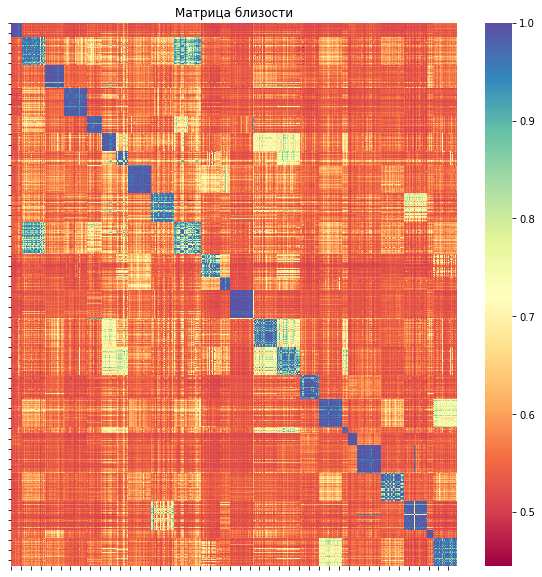

In [25]:
corpus_lsi = lsi[corpus]
index = similarities.MatrixSimilarity(lsi[corpus])
sims = index[corpus_lsi]
sims  = (sims + 1)/2.
plt.figure(figsize = (10,10))
sns.heatmap(data=sims, cmap = 'Spectral').set(xticklabels=[], yticklabels=[])
plt.title("Матрица близости")
plt.show()

### Главные компоненты

In [33]:
X = [0] * len(df)
Y = [0] * len(df)
for i in range(len(df)):
    vec = corpus[i]
    LSI_topics = (lsi[vec])
    for topic in LSI_topics:
        if topic[0] == 0:
            X[i] = topic[1]
        elif topic[0] == 1:
            Y[i] = topic[1]

vis_df = pd.DataFrame({'X': X, 'Y': Y, 'topic' : df.event})

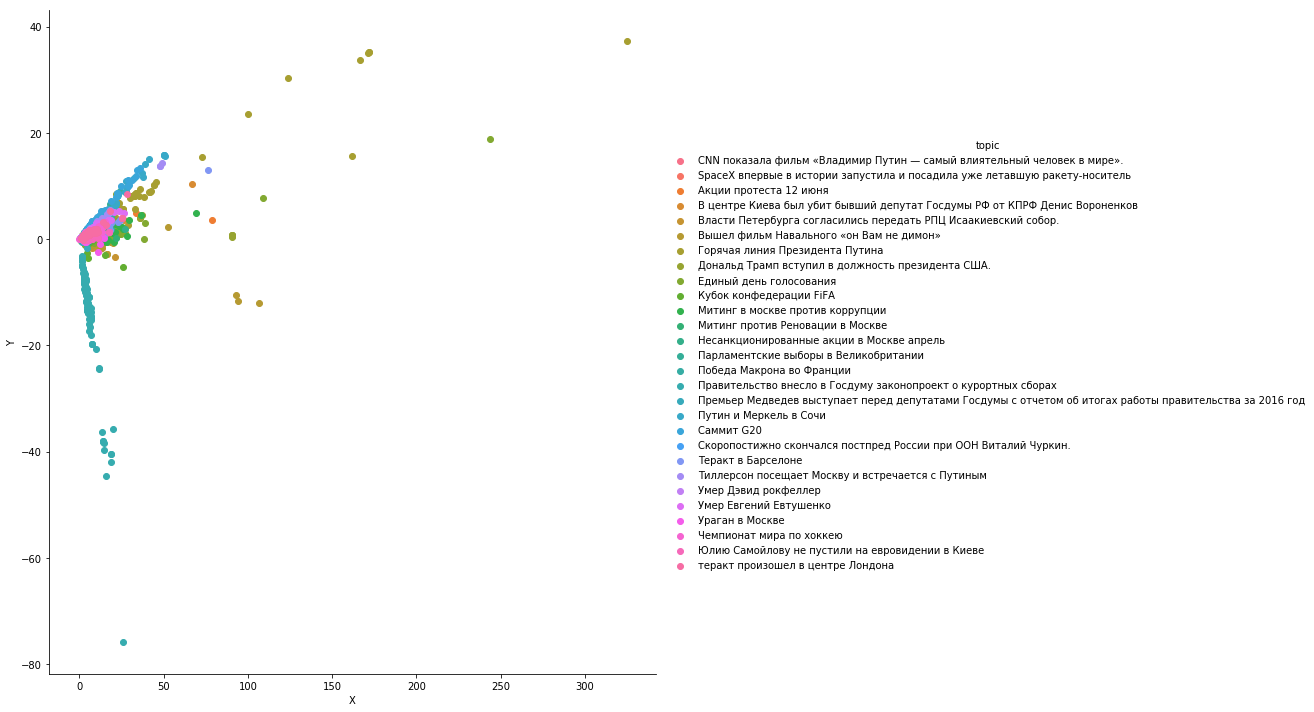

In [34]:
sns.FacetGrid(vis_df, hue="topic", size = 10).map(plt.scatter, "X", "Y").add_legend()

### Truncated SVD и TSNE

#### t-SNE
t-SNE (t-distributed Stochastic Neighbor Embedding) — техника нелинейного снижения размерности и визуализации многомерных переменных. Она разработана специально для данных высокой размерности Л. ван дер Маатеном и Д. Хинтоном. t-SNE — это итеративный алгоритм, основанный на вычислении попарных расстояний между всеми объектами (в том числе поэтому он довольно медленный).

![TSNE](TSNE.jpg)

In [9]:
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [29]:
vectors = TfidfVectorizer().fit_transform(df.text) # строим тф-идф матрицу документ-слово
X_reduced = TruncatedSVD(n_components=5, random_state=0).fit_transform(vectors) # оставляем n главных компонент

In [30]:
%%time
X_embedded = TSNE(n_components=2, perplexity=5, verbose=0).fit_transform(X_reduced) # строим мэппинг в двухмерную плоскость с TSNE

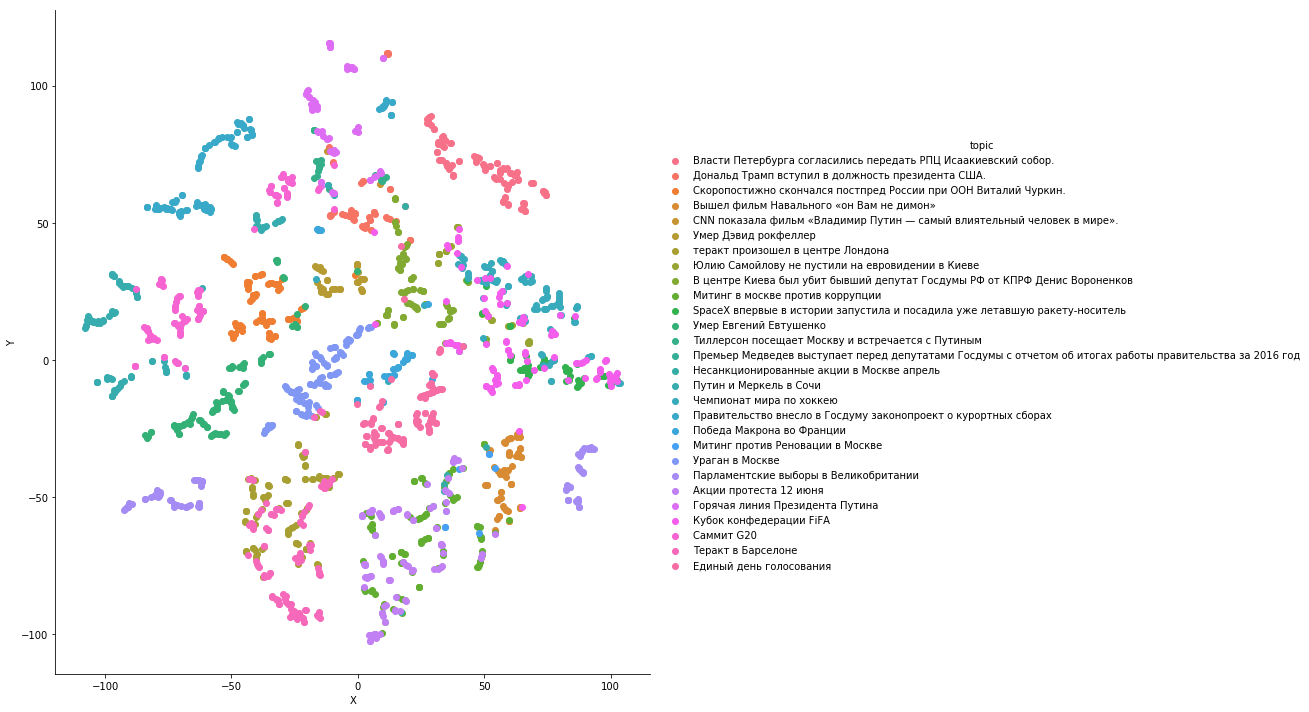

In [31]:
vis_df = pd.DataFrame({'X': X_embedded[:, 0], 'Y': X_embedded[:, 1], 'topic' : df.event})
sns.FacetGrid(vis_df, hue="topic", size=10).map(plt.scatter, "X", "Y").add_legend()

Advanced: [bigARTM](https://bigartm.readthedocs.io/en/stable/tutorials/python_tutorial.html)

### Задание: классификация

#### Данные

Скачиваются по [ссылке](https://drive.google.com/open?id=1gJEpwM3zdV5xe9nRU0VwQmGTiOTQdp10). Это отзывы пользователей на фильмы с КиноПоиска.

In [6]:
import pandas as pd

In [7]:
df = pd.read_csv('reviews.csv')

In [8]:
df.head()

,label,text
0,1,Эпиграф Добро которое ты делаешь от сердца ты ...
1,1,Теперь это один из моих любимых фильмов в жанр...
2,1,Что скрыто в фильме Лучше не бывает Одна шикар...
3,1,Перед нами очень милое и доброе кино которое л...
4,1,Завязка Мелвин Удал популярный писатель Нет не...


#### Задание

С помощью TruncatedSVD постройте векторное представление текстов в датасете.
Обучите на этих представлениях любой классификатор. Попробуйте разное количество компонент в интерванле от 30 до 300. Какое страдотало лучше?